# GET THE COMMENTS FOR EACH SUBMISSION AND BUILD A DATASET

### IMPORTS

In [1]:
import praw
import pandas as pd
import numpy as np
import re
from collections import defaultdict
import json
import time
from datetime import datetime, timezone

# SETUP FOR THE PRAW API WRAPPER
reddit = praw.Reddit(

client_id="bzcg8W-P-BdVy5N2N7JLbQ",

client_secret="q_5XGJ8gEI33-PO2p0LSFRG4DWNtIQ",

user_agent= "my-user-agent")

In [2]:
# DEFINE THE SUBREDDIT WE ARE GOING TO USE
subreddit = reddit.subreddit("IsraelPalestine")

In [12]:
# Read the data we have and subset it
df = pd.read_csv("RedditSubmissionsClean.csv")
df = df.query("subreddit == 'r/IsraelPalestine'").reset_index(drop = True).drop(["Unnamed: 0", "subreddit"], axis = 1)
df

,upvotes,date,title,username,text,post_id
0,16,2023-07-01,How likely is a peace treaty between Israel an...,u/ANobodyBoy,Either for a two-state solution or a one-state...,14o273q
1,5,2023-07-01,The lies of the anti-zionist movement,u/One-Trash3743,Antizionists always claim that they're not aga...,14niaul
2,1,2023-07-01,THE KINGDOM OF JERUSALEM IS FOREVER,u/TheBasedFeudalist163,Reject the false dichotomy both states are the...,14nmufa
3,1,2023-07-01,Anyone looking to discuss the conflict,u/Salty_Werewolf6532,Looking for a pro Palestinian to discuss the c...,14nt4nu
4,2,2023-07-02,Does anyone think a one state solution is even...,u/SoleySaul,I have never been a proponent of a one state s...,14opxhk
...,...,...,...,...,...,...
6662,100,2024-04-29,Short view of the conflict by an Israeli,u/Minute_Can_9561,"So, long story short, I'm an Israeli, around 3...",1cfpkbi
6663,0,2024-04-29,"Is Chanting ""Death to America"" Freedom of Speech?",u/vjlikebj,The University protestors have crossed the lin...,1cfpnyc
6664,16,2024-04-29,Do Israel need to eliminate the political bill...,u/Ok-Pack-8866,"The short answer is ""Yes"" - for the very long ...",1cfvhji
6665,108,2024-04-29,Went to deliver supplies to protesting student...,u/Let_See_9915,Today I spent over 100 USD on food and deliver...,1cfrwfv


### GETTING THE SUBMISSION OBJECT FOR EVERY SUBMISSION ID AND GETTING THE COMMENT FOREST OBJECT FOR EACH SUBMISSION

#### Divide in batches otherwise the requests fail

In [13]:
df["submission_object"] = [reddit.submission(id = post) for post in df["post_id"]]

In [24]:
batch1 = [sub.comments for sub in df["submission_object"][:1000]]

In [25]:
batch2 = [sub.comments for sub in df["submission_object"][1000:2000]]

In [27]:
batch3 = [sub.comments for sub in df["submission_object"][2000:3000]]

In [30]:
batch4 = [sub.comments for sub in df["submission_object"][3000:4000]]

In [28]:
batch5 = [sub.comments for sub in df["submission_object"][4000:5000]]

In [29]:
batch6 = [sub.comments for sub in df["submission_object"][5000:]]

In [31]:
batch_joined = batch1 + batch2 + batch3 + batch4 + batch5 + batch6

In [34]:
df["comment_forest"] = batch_joined

### EXTRACTING THE COMMENT ORDER AND COMMENT DATA FROM THE COMMENT FOREST

#### Useful functions

In [47]:
def fetch_comments(batch, depth = 1):

    """
    Args:
        batch: a comment forest of the type provided by PRAW.
        depth: optional depth parameter which 
                keeps track of how deep in the comment thread 
                the function is operating.
    Returns:
        A list of comments and their depths after processing 
        the entire post and its nested replies.

    """
    authors_list = []
    for comment in batch:
        if isinstance(comment, praw.models.MoreComments):
            continue
        authors_list.append((comment, depth))
        try:
            if len(comment.replies) > 0:
                authors_list.extend(fetch_comments(comment.replies, depth + 1))
        except:
            pass
    return authors_list

all_comments = fetch_comments(batch1[0])

In [207]:
def create_dataset(df):

    """
    Args:
        df: original pandas dataframe containing all Reddit submissions and their relative comment forests.
    Returns:
        pandas dataframe comprising every interaction between users, through the use of the function "fetch_comments".

    """

    # create a list containing the comment forests that have been unpacked by the function fetch_comments (which also returns the depth of the comment)
    all_comments = []
    for i in range(len(df)):
        comments = [(df.loc[i,"submission_object"],0)]
        comments += fetch_comments(df.loc[i,"comment_forest"])
        all_comments.append(comments)
    
    # Create empty dataframe where we will store results
    final_df = pd.DataFrame(columns = ["son_comment", "mother_comment", "comment_depth", "interacts_with_depth", "author_son", "author_mother", "text_son", "text_mother"])

    # Iterate through each comment forest
    for forest in all_comments:
        interactions = []
        # Iterate through comment/depth pairs and identify interactions.
        # An interaction happens if depth_new_comment = depth_old_comment + 1
        for i, (comment, depth) in enumerate(forest):
            for j in range(i - 1, -1, -1):
                if forest[j][1] < depth:
                    interactions.append({
                        'son_comment': comment, # store the comment object we are currently looking at
                        'mother_comment': forest[j][0], # store the comment from which our comment originates
                        'comment_depth': depth, # store the depth of the current comment
                        'interacts_with_depth': forest[j][1] # store the depth of the parent comment
                    })
                    break

        # if we do not find any interaction in the comment forest we ignore it
        if len(interactions) == 0:
            continue

        # Convert interactions list to DataFrame
        interactions_df = pd.DataFrame(interactions)
    
        # Get the authors of both comments for each interaction
        interactions_df['author_son'] = interactions_df.son_comment.apply(lambda x: x.author)
        interactions_df['author_mother'] = interactions_df.mother_comment.apply(lambda x: x.author)
        
        #get the date of publishing of both comments for each interaction
        interactions_df['son_date'] = interactions_df.son_comment.apply(lambda x: datetime.fromtimestamp(x.created_utc, tz=timezone.utc).strftime('%Y-%m-%d'))
        interactions_df['mother_date'] = interactions_df.mother_comment.apply(lambda x: datetime.fromtimestamp(x.created_utc, tz=timezone.utc).strftime('%Y-%m-%d'))

        # get the text of both comments for each interaction.
        # Note that we need to differentiate the attribute of the text in the case in which we are considering a submission and not a comment
        # In that case the attribute is ".selftext" and not ".body"
        interactions_df["text_son"] = [interactions_df.son_comment[x].body if interactions_df.comment_depth[x] != 0 else interactions_df.son_comment[x].selftext for x in range(len(interactions_df))]
        interactions_df["text_mother"] = [interactions_df.mother_comment[x].body if interactions_df.interacts_with_depth[x] != 0 else interactions_df.mother_comment[x].selftext for x in range(len(interactions_df))]

        # Concatenate every newly produces dataset to the final dataset and continue the loop
        final_df = pd.concat([final_df,interactions_df],axis = 0)

    return final_df

#### Dataset Creation

In [208]:
final_df = create_dataset(df)

In [209]:
final_df = final_df.reset_index(drop = True)

In [288]:
final_df.head(2)

,son_comment,mother_comment,comment_depth,interacts_with_depth,author_son,author_mother,text_son,text_mother,son_date,mother_date,upvotes_son,upvotes_mother,author_son_name,author_mother_name
0,jqax3k3,14o273q,1,0,KosherPigBalls,u/ANobodyBoy,Same as it’s always been; entirely within reac...,Either for a two-state solution or a one-state...,2023-07-01,2023-07-01,34,15,KosherPigBalls,u/ANobodyBoy
1,jqb87fg,jqax3k3,2,1,GrazingGeese,KosherPigBalls,beautifully said,Same as it’s always been; entirely within reac...,2023-07-01,2023-07-01,6,34,GrazingGeese,KosherPigBalls


#### Replacing missing users with data we have from torrents (the majority is still missing)

In [212]:
final_df.author_mother = [df[df.post_id == final_df.mother_comment[i]].username.iloc[0] if (final_df.author_mother[i] is None and final_df.interacts_with_depth[i] == 0) else final_df.author_mother[i] for i in range(len(final_df.author_mother))]

#### Getting the upvotes for each comment and submission

In [226]:
final_df["upvotes_son"] = [x.score for x in final_df.son_comment]
final_df["upvotes_mother"] = [x.score for x in final_df.mother_comment]

#### Final cleaning

In [247]:
# Get the name attribute of the users who post
final_df["author_son_name"] = final_df.author_son.apply(lambda x: x.name if (not isinstance(x,str)) and x else x)
final_df["author_mother_name"] = final_df.author_mother.apply(lambda x: x.name if (not isinstance(x,str)) and x else x)

In [249]:
# Drop irrelevant columns and rename the rest
final_final_df = final_df.drop(["son_comment","mother_comment","author_son","author_mother"],axis = 1)
final_final_df = final_final_df.rename(columns ={"author_son_name" : "author_son","author_mother_name":"author_mother"})

In [280]:
# Deal with dtype problems that arise when exporting the dataset
final_final_df.comment_depth = final_final_df.comment_depth.astype(int)
final_final_df.interacts_with_depth = final_final_df.interacts_with_depth.astype(int)
final_final_df["comment_depth"] = pd.to_numeric(final_final_df["comment_depth"], downcast="unsigned")
final_final_df["interacts_with_depth"] = pd.to_numeric(final_final_df["interacts_with_depth"], downcast="unsigned")

#### Saving data

In [285]:
final_final_df.to_json("network_data.json", index = False)

#### Total Nodes/Authors in the dataset

In [289]:
list_authors = set(final_df.author_mother.tolist() + final_df.author_son.tolist())
print(f"Total numbers of users in the network: {len(list_authors)}")

Total numbers of users in the network: 35101


-------------

### VISUALIZATION

In [150]:
unique_inter = final_df.groupby(["author_son","author_mother"]).count().reset_index()

In [156]:
n_interactions = unique_inter.groupby("author_son")["author_mother"].count().sort_values(ascending = False).reset_index()

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


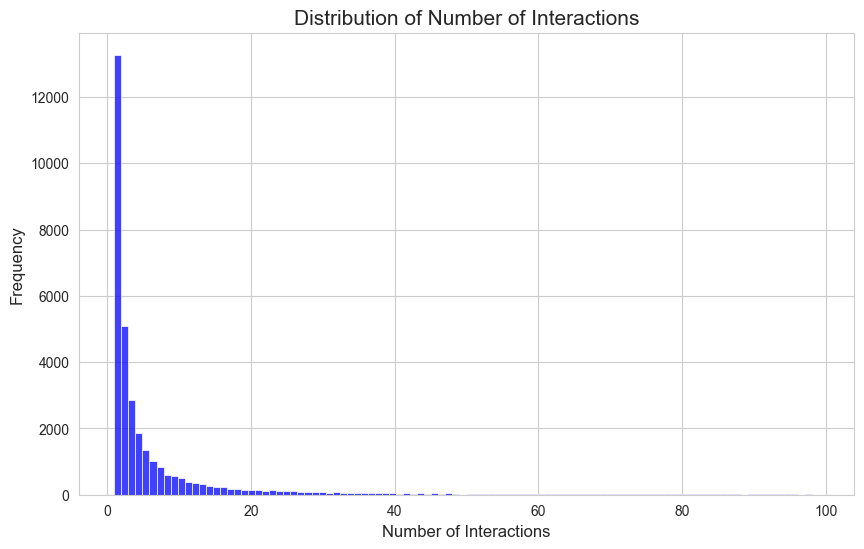

In [173]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure and axis
plt.figure(figsize=(10, 6))

# Plot the distribution of the number of interactions
sns.histplot(n_interactions[n_interactions.author_mother <100]['author_mother'], bins=100, color='blue')

# Add titles and labels
plt.title('Distribution of Number of Interactions', fontsize=15)
plt.xlabel('Number of Interactions', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.show()


In [43]:
batchtry = df["comment_forest"][0]

In [ ]:
create_dataset(batchtry)